In [1]:
%matplotlib inline

In [2]:
import os
import sys 
import pathlib

In [3]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [4]:
HOME = pathlib.Path.home()

In [5]:
sys.path.append('../../../utils/')

In [6]:
from set_root_dir import set_root_dir

In [7]:
from matplotlib import pyplot as plt

In [8]:
import proplot as plot

In [9]:
import numpy as np
import pandas as pd

In [10]:
import xarray as xr

In [11]:
xr.__version__

'0.15.1'

In [12]:
rpath = set_root_dir(root='gdata')

In [118]:
# %%writefile ../../../utils/get_GCM_outputs.py
def get_GCM_outputs(provider='CDS', GCM='ECMWF', var_name='T2M', period='hindcasts', rpath=None, domain=[90, 300, -65, 50], step=None, verbose=False, flatten=True):
    
    """
    Get the GCM outputs 
    
    Parameters
    ----------
    
    - provider: in ['CDS','IRI','JMA'] 
    - GCM: name of the GCM 
    - var_name: in ['T2M', 'PRECIP']
    - period: in ['hindcasts', 'forecasts']
    - rpath (root path, pathlib.Path object, see `set_root_dir` in the utils module)
    - domain [lon_min, lon_max, lat_min, lat_max]
    - step ( in [3, 4, 5] )
    - verbose: Boolean, whether to print names of files successfully opened
    - flatten: Boolean, whether of not to stack the dataset over the spatial (+ member if present) dimension
    to get 2D fields
    
    Return
    ------ 
    
    - dset: xarray.Dataset concatenated along the time dimension 

    """
    
    
    import pathlib
    import xarray as xr
    
    ipath = rpath /  'GCMs'/ 'processed' / period / provider / GCM / var_name
    
    lfiles_gcm = list(ipath.glob(f"{GCM}_{var_name}_seasonal_anomalies_interp_????_??.nc"))
    
    if (period == 'hindcasts') and (len(lfiles_gcm) ) < 200: 
        print(f"Something wrong with the number of files in the list for the {period} period, the length is {len(lfiles_gcm)}")
    if (period == 'forecasts') and (len(lfiles_gcm) ) < 20:
        print(f"Something wrong with the number of files in the list for the {period} period, the length is {len(lfiles_gcm)}")
    
    lfiles_gcm.sort()
    
    print(f"first file is {str(lfiles_gcm[0])}")
    print(f"last file is {str(lfiles_gcm[-1])}")

    dset_l = []
    
    for fname in lfiles_gcm: 
        
        dset = xr.open_dataset(fname)[[var_name.lower()]]

        
        # select the domain 
        
        if domain is not None: 
            dset = dset.sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3]))
        if step is not None: 
            dset = dset.sel(step=step)
         
                
        if verbose: 
            print(f"successfully opened and extracted {fname}")
    
        dset_l.append(dset)

    dset = xr.concat(dset_l, dim='time')
    
    # now get the dimensions, will be returned along with the dataset itself, 
    # regarding of whether the dataset is flattened 
    
    dims_tuple = (dset.dims, dset[var_name.lower()].dims) 

    if flatten: 
        
        if 'member' in dset.dims: 
            
            dset = dset.stack(z=('member','lat','lon'))
        
        else: 
            
            dset = dset.stack(z=('lat','lon'))    
    
    return dset, dims_tuple

In [105]:
dset_t2m_ecmwf_hindcasts, dims = get_GCM_outputs(provider='CDS', GCM='ECMWF', var_name='T2M', period='hindcasts', rpath=rpath, domain=[90, 300, -65, 50], step=3, flatten=True)

first file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/CDS/ECMWF/T2M/ECMWF_T2M_seasonal_anomalies_interp_1993_01.nc
last file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/CDS/ECMWF/T2M/ECMWF_T2M_seasonal_anomalies_interp_2016_12.nc


### get the dimensions IN ORDER for the variable of interest in a tuple

In [114]:
shapes_hindcasts  = tuple([dims[0][k] for k in dims[1]])

In [116]:
shapes_hindcasts

(288, 25, 47, 85)

In [15]:
dset_t2m_ecmwf_hindcasts

<xarray.Dataset>
Dimensions:     (time: 288, z: 99875)
Coordinates:
    surface     int64 0
    step        int64 3
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    valid_time  (time) datetime64[ns] 1993-05-01 1993-06-01 ... 2017-04-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * z           (z) MultiIndex
  - member      (z) int64 0 0 0 0 0 0 0 0 0 0 ... 24 24 24 24 24 24 24 24 24 24
  - lat         (z) float64 -65.0 -65.0 -65.0 -65.0 ... 50.0 50.0 50.0 50.0
  - lon         (z) float64 90.0 92.5 95.0 97.5 ... 292.5 295.0 297.5 300.0
Data variables:
    t2m         (time, z) float64 -0.3134 -0.06035 0.01654 ... 0.7948 0.7617
Attributes:
    regrid_method:  bilinear

In [16]:
dset_precip_ecmwf_hindcasts = get_GCM_outputs(provider='CDS', GCM='ECMWF', var_name='PRECIP', period='hindcasts', rpath=rpath, domain=[90, 300, -65, 50], step=3, flatten=True)

first file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/CDS/ECMWF/PRECIP/ECMWF_PRECIP_seasonal_anomalies_interp_1993_01.nc
last file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/CDS/ECMWF/PRECIP/ECMWF_PRECIP_seasonal_anomalies_interp_2016_12.nc


In [17]:
dset_precip_ecmwf_hindcasts.drop('valid_time')

<xarray.Dataset>
Dimensions:  (time: 288, z: 99875)
Coordinates:
    surface  int64 0
    step     int64 3
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * z        (z) MultiIndex
  - member   (z) int64 0 0 0 0 0 0 0 0 0 0 0 ... 24 24 24 24 24 24 24 24 24 24
  - lat      (z) float64 -65.0 -65.0 -65.0 -65.0 -65.0 ... 50.0 50.0 50.0 50.0
  - lon      (z) float64 90.0 92.5 95.0 97.5 100.0 ... 292.5 295.0 297.5 300.0
Data variables:
    precip   (time, z) float64 1.064e-09 1.613e-09 ... 9.526e-09 6.534e-09
Attributes:
    regrid_method:  bilinear

In [18]:
dset_t2m_ecmwf_forecasts = get_GCM_outputs(provider='CDS', GCM='ECMWF', var_name='T2M', period='forecasts', rpath=rpath, domain=[90, 300, -65, 50], step=3, flatten=True)

first file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/forecasts/CDS/ECMWF/T2M/ECMWF_T2M_seasonal_anomalies_interp_2017_01.nc
last file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/forecasts/CDS/ECMWF/T2M/ECMWF_T2M_seasonal_anomalies_interp_2019_12.nc


In [19]:
dset_precip_ecmwf_forecasts = get_GCM_outputs(provider='CDS', GCM='ECMWF', var_name='PRECIP', period='forecasts', rpath=rpath, domain=[90, 300, -65, 50], step=3, flatten=True)

first file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/forecasts/CDS/ECMWF/PRECIP/ECMWF_PRECIP_seasonal_anomalies_interp_2017_01.nc
last file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/forecasts/CDS/ECMWF/PRECIP/ECMWF_PRECIP_seasonal_anomalies_interp_2019_12.nc


In [20]:
dset_precip_ecmwf_hindcasts

<xarray.Dataset>
Dimensions:     (time: 288, z: 99875)
Coordinates:
    surface     int64 0
    step        int64 3
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    valid_time  (time) datetime64[ns] 1993-05-01 1993-06-01 ... 2017-04-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * z           (z) MultiIndex
  - member      (z) int64 0 0 0 0 0 0 0 0 0 0 ... 24 24 24 24 24 24 24 24 24 24
  - lat         (z) float64 -65.0 -65.0 -65.0 -65.0 ... 50.0 50.0 50.0 50.0
  - lon         (z) float64 90.0 92.5 95.0 97.5 ... 292.5 295.0 297.5 300.0
Data variables:
    precip      (time, z) float64 1.064e-09 1.613e-09 ... 9.526e-09 6.534e-09
Attributes:
    regrid_method:  bilinear

In [21]:
dset_precip_ecmwf_hindcasts.nbytes / 1e6

230.917928

### now shifts the time index so that the time corresponds to the time of the forecast, not the initialisation time 

### also shifts to the end of the month, to correspond to the convention used in the target time-series 

In [22]:
step = 3

In [23]:
# %%writefile ../../../utils/shift_dset_time.py
def shift_dset_time(dset, name='time', step=3, end_month = True): 
    """
    Shift the time index of a xarray.Dataset by the specified number of steps (in month)
    
    Parameters
    ----------
    - name: str, the name of the time variable (usually 'time')
    - step: the number of steps (in months) by which to shift the time index 
    - end_month: Boolean, if True, the day of the month is set to be the last 
    day of the month. Note that if the xarray Dataset, the day or the month is not 
    equal to 1, it will return an error and fail 
    
    Returm
    ------ 
    
    - dset: the xarray.Dataset with the shifted time variable 
    
    """
    if end_month: 
        if not (np.alltrue(np.ones(len(dset[name].to_index())) == dset[name].to_index().day.values)): 
            print("""warning, the end_month argument is set to True,
            but the time variable does NOT start at the beinning of the month
            """)
        else: 
            dset[name] = dset.time.to_index().shift(periods = step + 1, freq='M')
    else: 
        dset[name] = dset.time.to_index().shift(periods = step, freq='MS')
    
    return dset 

In [24]:
dset_t2m_ecmwf_hindcasts

<xarray.Dataset>
Dimensions:     (time: 288, z: 99875)
Coordinates:
    surface     int64 0
    step        int64 3
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    valid_time  (time) datetime64[ns] 1993-05-01 1993-06-01 ... 2017-04-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * z           (z) MultiIndex
  - member      (z) int64 0 0 0 0 0 0 0 0 0 0 ... 24 24 24 24 24 24 24 24 24 24
  - lat         (z) float64 -65.0 -65.0 -65.0 -65.0 ... 50.0 50.0 50.0 50.0
  - lon         (z) float64 90.0 92.5 95.0 97.5 ... 292.5 295.0 297.5 300.0
Data variables:
    t2m         (time, z) float64 -0.3134 -0.06035 0.01654 ... 0.7948 0.7617
Attributes:
    regrid_method:  bilinear

In [25]:
dset_precip_ecmwf_hindcasts

<xarray.Dataset>
Dimensions:     (time: 288, z: 99875)
Coordinates:
    surface     int64 0
    step        int64 3
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    valid_time  (time) datetime64[ns] 1993-05-01 1993-06-01 ... 2017-04-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * z           (z) MultiIndex
  - member      (z) int64 0 0 0 0 0 0 0 0 0 0 ... 24 24 24 24 24 24 24 24 24 24
  - lat         (z) float64 -65.0 -65.0 -65.0 -65.0 ... 50.0 50.0 50.0 50.0
  - lon         (z) float64 90.0 92.5 95.0 97.5 ... 292.5 295.0 297.5 300.0
Data variables:
    precip      (time, z) float64 1.064e-09 1.613e-09 ... 9.526e-09 6.534e-09
Attributes:
    regrid_method:  bilinear

### shift the time index 

In [26]:
dset_t2m_ecmwf_hindcasts = shift_dset_time(dset_t2m_ecmwf_hindcasts)

In [27]:
dset_precip_ecmwf_hindcasts = shift_dset_time(dset_precip_ecmwf_hindcasts)

### scikit learn imports 

### scaler 

In [28]:
from sklearn.preprocessing import StandardScaler

### PCA 

In [29]:
from sklearn.decomposition import kernel_pca, pca
from eofs.xarray import Eof

### creates the weights now 

In [30]:
coslat = np.cos(np.deg2rad(dset_t2m_ecmwf_forecasts.coords['lat'].data))
wgts = np.sqrt(coslat)[..., np.newaxis]

In [31]:
wgts.shape

(99875, 1)

### pipeline 

In [32]:
from sklearn.pipeline import make_pipeline

### TARGETS 

In [33]:
dpath_target = HOME / 'research' / 'Smart_Ideas' / 'outputs' / 'targets' / 'NZ_regions' / 'NZ_6_regions'

#### RAINFALL 

In [34]:
target_var = 'RAIN'

In [35]:
region_name = 'NNI'

In [36]:
targets_rain = []
for region_name in ['NNI','WNI','ENI','NSI','WSI','ESI']: 
    target = pd.read_csv(dpath_target / target_var / region_name / f'TS_NZ_region_{region_name}_{target_var}_3_quantiles_anoms.csv', index_col=0, parse_dates=True)
    target.columns = pd.MultiIndex.from_product([[region_name],target.columns])
    targets_rain.append(target)

In [37]:
targets_rain = pd.concat(targets_rain, axis=1)

In [38]:
targets_rain.head()

NNI                           WNI                    \
               Rain_bc cat_3   anomalies     Rain_bc cat_3   anomalies   
time                                                                     
1979-03-31  470.822673     3  176.364977  357.294404     3   49.163323   
1979-04-30  546.720000     3  229.631158  440.482174     3  121.697362   
1979-05-31  493.002426     3  134.029467  523.612630     3  167.590461   
1979-06-30  429.186337     2   13.302417  404.922302     2   -9.359534   
1979-07-31  549.575990     3   77.774812  407.600080     1  -53.438670   

                   ENI                           NSI                    \
               Rain_bc cat_3   anomalies     Rain_bc cat_3   anomalies   
time                                                                     
1979-03-31  472.045206     3  180.723225  498.174979     3   66.560252   
1979-04-30  492.918286     3  181.818099  564.466858     3  129.367183   
1979-05-31  514.622032     3  174.868212  652.528876     3  163.604985   
1979-06-30  306.615937     1  -71.251663  579.009926     2   25.933292   
1979-07-31  368.729460     1  -65.591395  602.019278     2   18.614145   

                   WSI                          ESI                    
               Rain_bc cat_3   anomalies    Rain_bc cat_3   anomalies  
time                                                                   
1979-03-31  783.318801     3  143.904216  221.08315     3   49.951240  
1979-04-30  690.960327     3   94.298941  215.23890     3   51.450578  
1979-05-31  730.426131     3   78.714666  294.27635     3  126.515812  
1979-06-30  662.720245     2    1.927881  165.33315     2   -0.559937  
1979-07-31  606.331144     2  -34.887512  187.18665     3   12.600620

In [39]:
targets_rain_anomalies = targets_rain.loc[:, (slice(None), ["anomalies"])]

In [40]:
target_rain_terciles = targets_rain.loc[:, (slice(None), ["cat_3"])]

In [41]:
targets_rain_anomalies.columns = targets_rain_anomalies.columns.droplevel(1)

In [42]:
targets_rain_anomalies.corr()

,NNI,WNI,ENI,NSI,WSI,ESI
NNI,1.000000,0.628569,0.660530,0.467320,0.052418,0.303507
WNI,0.628569,1.000000,0.517255,0.647163,0.373477,0.379218
ENI,0.660530,0.517255,1.000000,0.246156,-0.112307,0.322509
NSI,0.467320,0.647163,0.246156,1.000000,0.591171,0.446934
WSI,0.052418,0.373477,-0.112307,0.591171,1.000000,0.146743
ESI,0.303507,0.379218,0.322509,0.446934,0.146743,1.000000


In [43]:
target_rain_terciles.columns = target_rain_terciles.columns.droplevel(1)

In [44]:
target_rain_terciles.corr()

,NNI,WNI,ENI,NSI,WSI,ESI
NNI,1.000000,0.490320,0.548107,0.380331,0.045026,0.294836
WNI,0.490320,1.000000,0.416058,0.518791,0.317928,0.353460
ENI,0.548107,0.416058,1.000000,0.166818,-0.114624,0.263832
NSI,0.380331,0.518791,0.166818,1.000000,0.508610,0.411055
WSI,0.045026,0.317928,-0.114624,0.508610,1.000000,0.138744
ESI,0.294836,0.353460,0.263832,0.411055,0.138744,1.000000


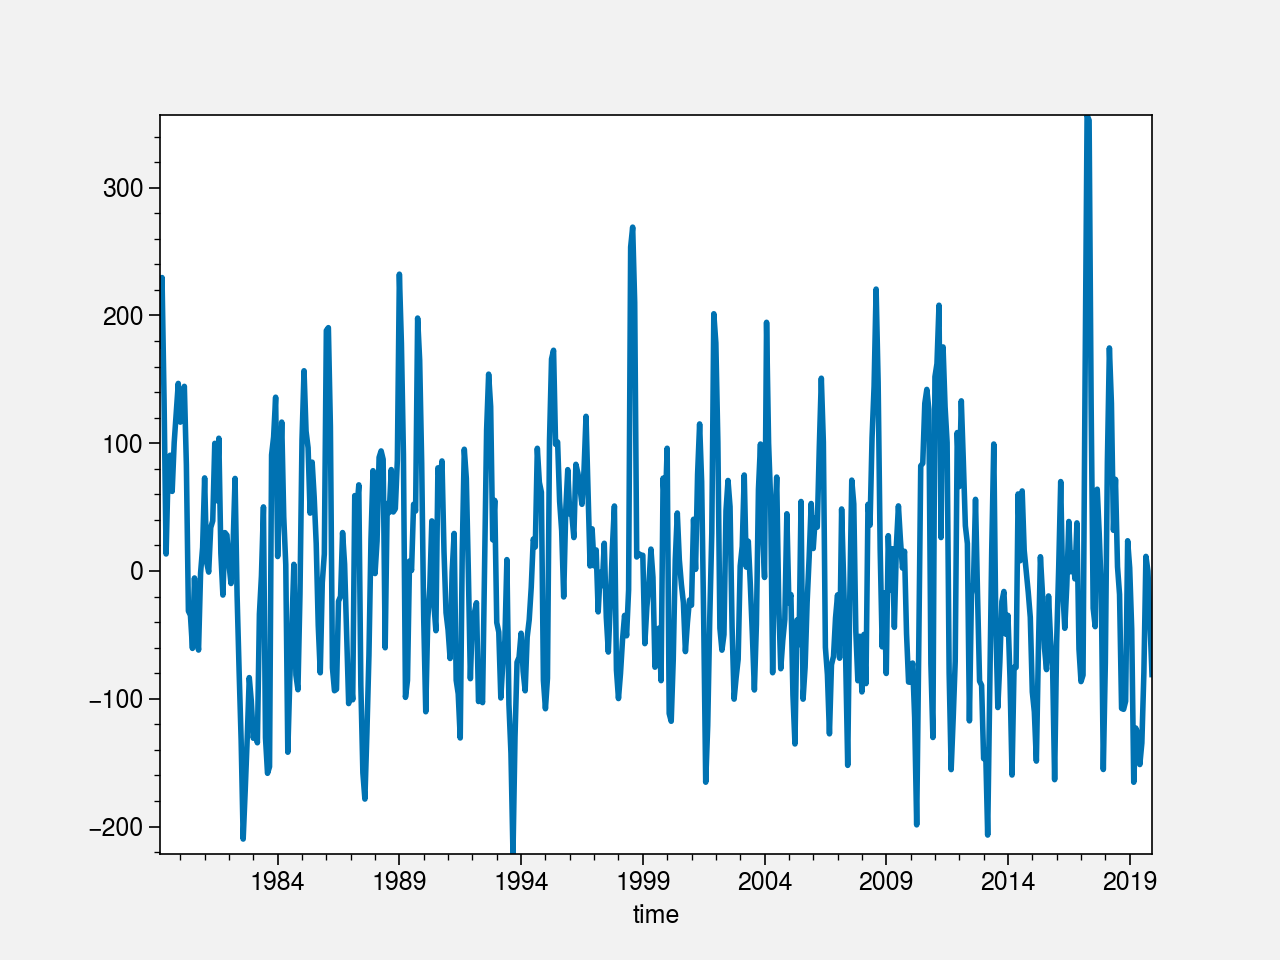

In [45]:
f, ax = plt.subplots()
targets_rain_anomalies.NNI.plot(ax=ax, lw=2)
ax.grid(ls=':', color='w')

### reduce the dimensionality of the hindcasts / forecasts using PCA 

### Get the data in a numpy array 

#### loads in case the underlying data structures are dask arrays 

In [46]:
dset_t2m_ecmwf_hindcasts.load()

<xarray.Dataset>
Dimensions:     (time: 288, z: 99875)
Coordinates:
    surface     int64 0
    step        int64 3
  * time        (time) datetime64[ns] 1993-04-30 1993-05-31 ... 2017-03-31
    valid_time  (time) datetime64[ns] 1993-05-01 1993-06-01 ... 2017-04-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * z           (z) MultiIndex
  - member      (z) int64 0 0 0 0 0 0 0 0 0 0 ... 24 24 24 24 24 24 24 24 24 24
  - lat         (z) float64 -65.0 -65.0 -65.0 -65.0 ... 50.0 50.0 50.0 50.0
  - lon         (z) float64 90.0 92.5 95.0 97.5 ... 292.5 295.0 297.5 300.0
Data variables:
    t2m         (time, z) float64 -0.3134 -0.06035 0.01654 ... 0.7948 0.7617
Attributes:
    regrid_method:  bilinear

In [47]:
X_t2m_train = dset_t2m_ecmwf_hindcasts['t2m'].data

### initialise the standard scaler 

In [48]:
scaler_t2m = StandardScaler()

### fit and transform 

In [49]:
X_t2m_train = scaler_t2m.fit_transform(X_t2m_train)

### verify that mean ~= 0 and std ~= 1 for all features (grid points)

In [50]:
X_t2m_train.mean(0)

array([1.54197642e-18, 1.37235902e-16, 1.07938350e-17, ...,
       1.60751042e-16, 1.53426654e-16, 9.79155029e-17])

In [51]:
X_t2m_train.std(0)

array([1., 1., 1., ..., 1., 1., 1.])

### initialise the PCA, 

#### percentage of variance we want to keep, scikit - learn will automatically select the number of PCs 

In [52]:
percent_variance = 0.8

#### initialisation 

In [56]:
skpca_t2m = pca.PCA(n_components=percent_variance)

#### fit AND transform, returns the PCs 

In [57]:
skpca_t2m_PCs_train = skpca_t2m.fit_transform(X_t2m_train)

### shape, number of pcs, do not forget that the 'member' dimension is also included in the z stacked dimension (member, lat, lon)

In [58]:
skpca_t2m_PCs_train.shape

(288, 128)

In [59]:
n_pcs = skpca_t2m_PCs_train.shape[1]

In [60]:
print(n_pcs)

128


### gets the EOFs 

In [78]:
eofs_t2m_train = skpca_t2m.components_

In [79]:
eofs_t2m_train.shape

(128, 99875)

### reshape

In [84]:
dset_t2m_ecmwf_hindcasts.coords['z']

<xarray.DataArray 'lat' (z: 99875)>
array([-65., -65., -65., ...,  50.,  50.,  50.])
Coordinates:
    surface  int64 0
    step     int64 3
  * z        (z) MultiIndex
  - member   (z) int64 0 0 0 0 0 0 0 0 0 0 0 ... 24 24 24 24 24 24 24 24 24 24
  - lat      (z) float64 -65.0 -65.0 -65.0 -65.0 -65.0 ... 50.0 50.0 50.0 50.0
  - lon      (z) float64 90.0 92.5 95.0 97.5 100.0 ... 292.5 295.0 297.5 300.0

### Now calculate (project) the corresponding PCs in the forecast period

#### prior to that, transform using the Standard Scaler fitted over the hindcast period  

In [61]:
X_t2m_test =  dset_t2m_ecmwf_forecasts['t2m'].data

In [62]:
X_t2m_test = scaler_t2m.transform(X_t2m_test)

#### checks that the mean and the std are not too far off 0 and 1 respectively, note that due to temperarture trends, we expect an increase in the mean 

In [63]:
X_t2m_test.mean()

0.47473024315319323

In [64]:
X_t2m_test.std()

1.0115041448638695

#### now transforms using the pca object fitted previously on the training data 

In [65]:
skpca_t2m_PCs_test = skpca_t2m.transform(X_t2m_test)

### plots the PCs, casts these into a dataframe, with the correct time index 

In [69]:
df_skpca_t2m_PCs_train = pd.DataFrame(skpca_t2m_PCs_train, index=dset_t2m_ecmwf_hindcasts['time'].to_index())

In [71]:
df_skpca_t2m_PCs_test = pd.DataFrame(skpca_t2m_PCs_test, index=dset_t2m_ecmwf_forecasts['time'].to_index())

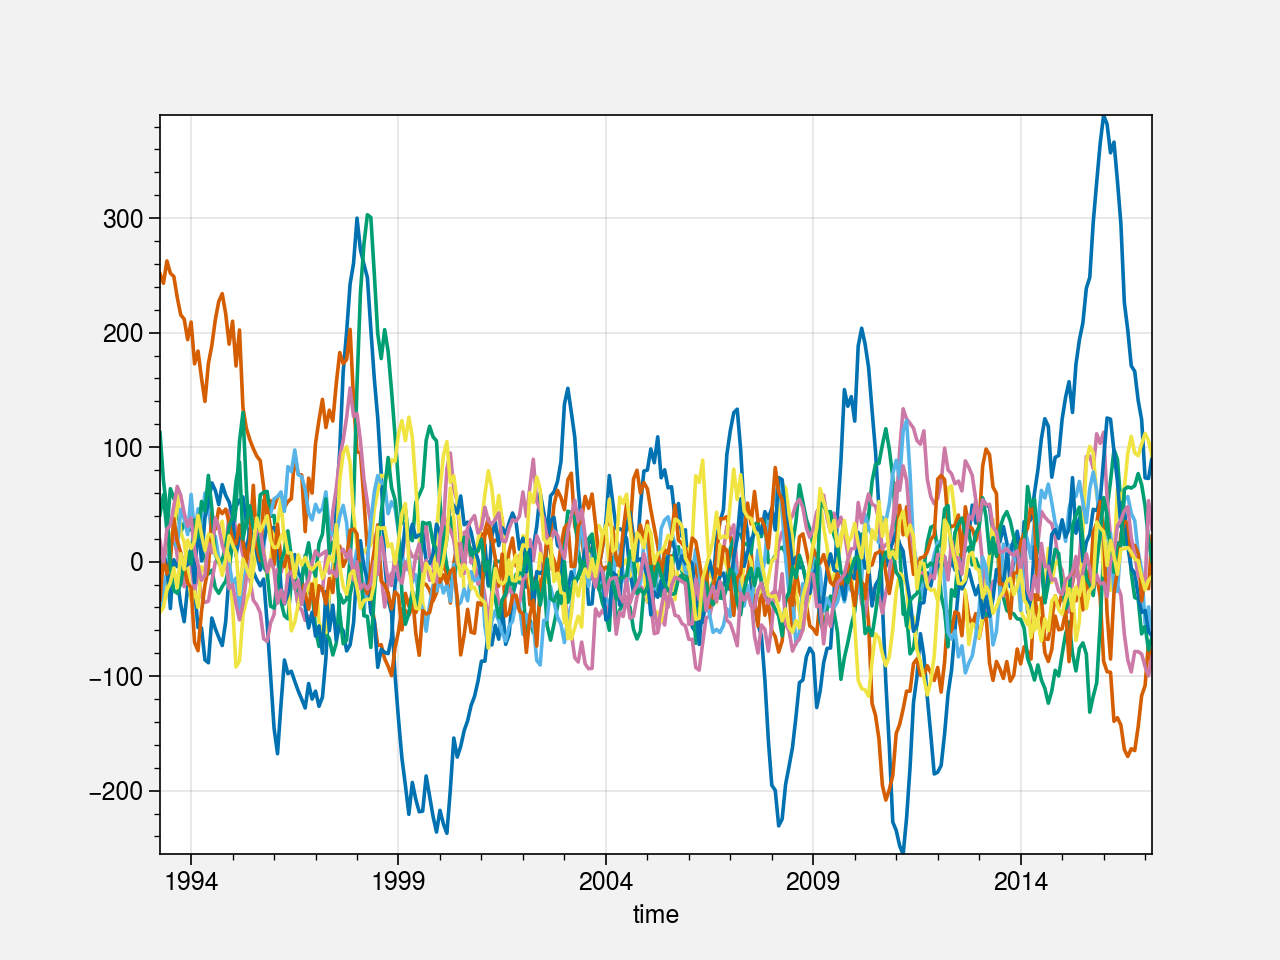

In [76]:
df_skpca_t2m_PCs_train.loc[:,0:10].plot(legend=None); 

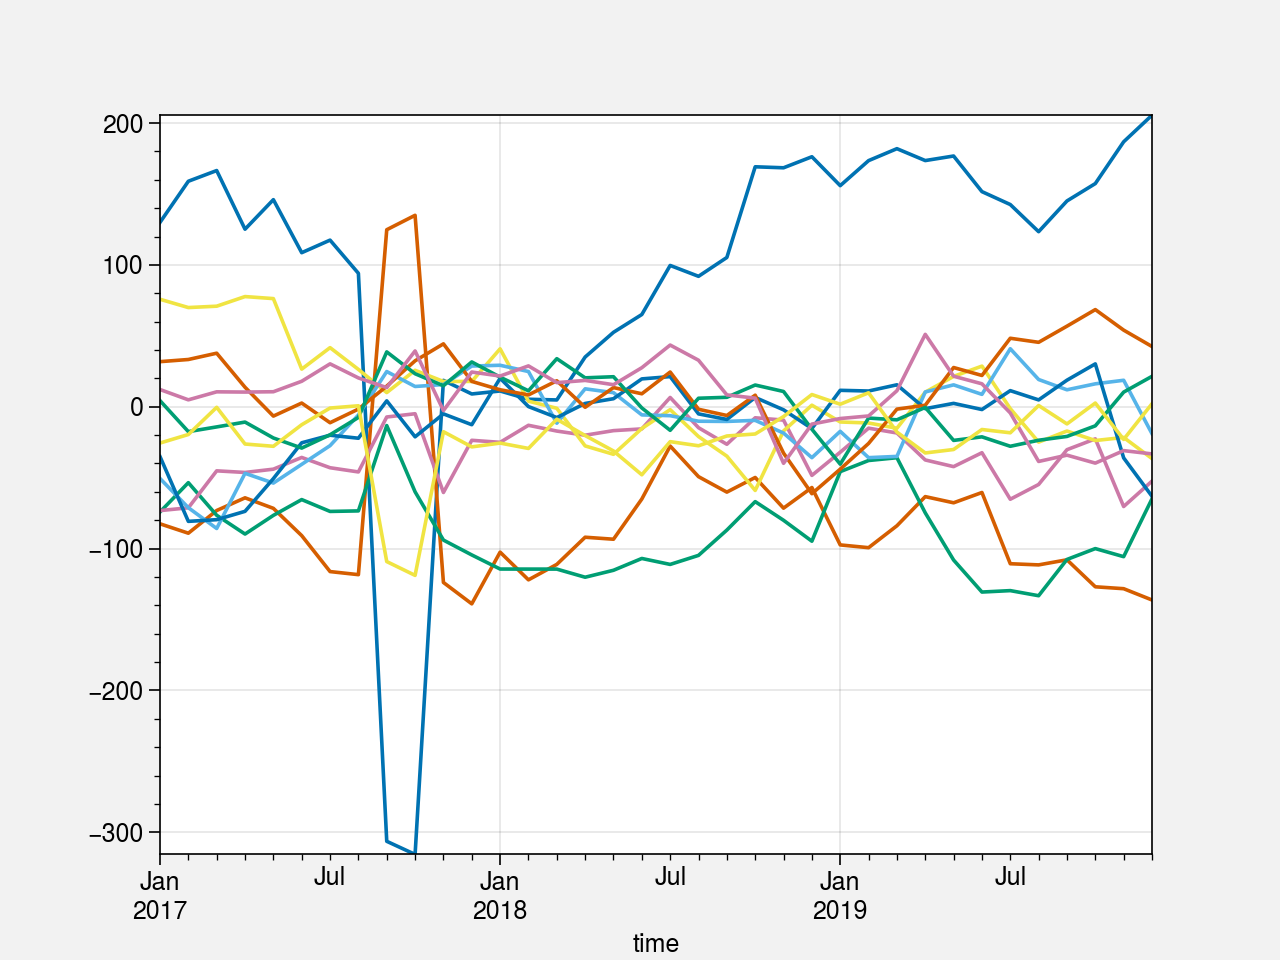

In [77]:
df_skpca_t2m_PCs_test.loc[:,0:10].plot(legend=None); 